## LightGBM Model

### Data Preparation

In [3]:
#Extend cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np

import shap
import lightgbm as lgb 

#### Load Dataset

In [ ]:
train = pd.read_csv('SBA_loans_train(1).csv')
test = pd.read_csv('SBA_loans_test(1).csv')

In [5]:
# Choose which columns to encode
cat_columns = ["City","State","Bank","BankState", "UrbanRural", "FranchiseCode",
               "NewExist", "RevLineCr","LowDoc", "Zip"]
response = "Defaulted"
# Change column types
for column in cat_columns:
    train[column] = train[column].astype('category')
    test[column] = test[column].astype('category')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337186 entries, 0 to 337185
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   City               337177 non-null  category
 1   State              337180 non-null  category
 2   Zip                337186 non-null  category
 3   Bank               336587 non-null  category
 4   BankState          336583 non-null  category
 5   NAICS              337186 non-null  int64   
 6   Term               337186 non-null  int64   
 7   NoEmp              337186 non-null  int64   
 8   NewExist           337140 non-null  category
 9   CreateJob          337186 non-null  int64   
 10  RetainedJob        337186 non-null  int64   
 11  FranchiseCode      337186 non-null  category
 12  UrbanRural         337186 non-null  category
 13  RevLineCr          335483 non-null  category
 14  LowDoc             336198 non-null  category
 15  DisbursementGross  337186 non-null

In [7]:
train.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
0,Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2.0,2,1,0,1,N,N,25000.0,0.0,25000.0,21250.0,1
1,SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2.0,0,0,0,0,N,N,52000.0,0.0,52000.0,46800.0,1
2,BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1.0,0,0,1,1,0,Y,150000.0,0.0,150000.0,127500.0,0
3,AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1.0,0,20,10625,2,Y,N,186959.0,0.0,100000.0,50000.0,1
4,HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1.0,0,0,1,1,0,Y,50000.0,0.0,50000.0,40000.0,0


In [8]:
# Train LightGBM
train_data = lgb.Dataset(train.drop(response, axis=1), label=train[response],
                            categorical_feature=cat_columns, free_raw_data=False)
test_data = lgb.Dataset(test.drop(response, axis=1), label=test[response],
                            categorical_feature=cat_columns, free_raw_data=False)

print("Number of Model features: ", train.shape[1]-1)

Number of Model features:  19


In [9]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
}
model = lgb.train(params=params, train_set=train_data, valid_sets=[test_data])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 59072, number of negative: 278114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25798
[LightGBM] [Info] Number of data points in the train set: 337186, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175191 -> initscore=-1.549274
[LightGBM] [Info] Start training from score -1.549274


#### LightGBM Contributions

Model contributions are returned in a numpy array with the shape (n_samples, n_features + 1).

The last column is the bias term.

In [10]:
test_predictions = model.predict(test.drop(response, axis=1), pred_contrib=False)
print("Number of predictions:", len(test_predictions))
print("First 10 predictions:", test_predictions[0:10])

Number of predictions: 112396
First 10 predictions: [0.00327795 0.0037612  0.00177997 0.00302086 0.00773443 0.01106398
 0.76449448 0.0088415  0.34534531 0.00478092]


In [11]:
test_contributions = model.predict(test.drop(response, axis=1), pred_contrib=True)
print("Contributions shape:", test_contributions.shape)

Contributions shape: (112396, 20)


Print Contributions and Bias term for the first record. 

Bias term is the last value in the array of the contributions.

In [12]:
print("First record contributions:", test_contributions[0][:-1])
print("Bias term (same for all records):", test_contributions[0][-1])

First record contributions: [-4.45019703e-02  6.59438017e-02 -2.94338067e-02 -2.08113991e-01
 -9.73224145e-02  1.10097240e-01 -1.52138420e+00  1.14863756e-02
  2.34165033e-02  1.72094497e-04 -9.35699000e-04 -3.75587081e-01
 -1.92025670e-01 -3.83745072e-02 -9.54536398e-03 -1.07759358e-01
  0.00000000e+00 -6.20177055e-03 -8.21134282e-02]
Bias term (same for all records): -3.2150709986414614


#### SHAP Values Summary Plot

In [13]:
def examine_all_reason_codes(data, shap_contribs, response_col):
    '''
    This function plots the SHAP values for all records in the dataset.
    Input:
        data: Pandas dataframe with the records used to calculate prediction and SHAP values
        shap_contribs: SHAP contributions for all records
        response_col: Name of the response column
    '''
    shap_cols = [x for x in test.columns if x != response_col]
    bias_term = shap_contribs[0][-1]
    df_contrib = pd.DataFrame(shap_contribs)
    #Pandas dataframe drop last column
    df_contrib = df_contrib.iloc[:, :-1]
    
    return shap.summary_plot(shap_values=df_contrib.values, 
                             features=data[shap_cols].values,
                             feature_names=shap_cols
                            )

Create Shaley Values Summary Plot for the Test data.

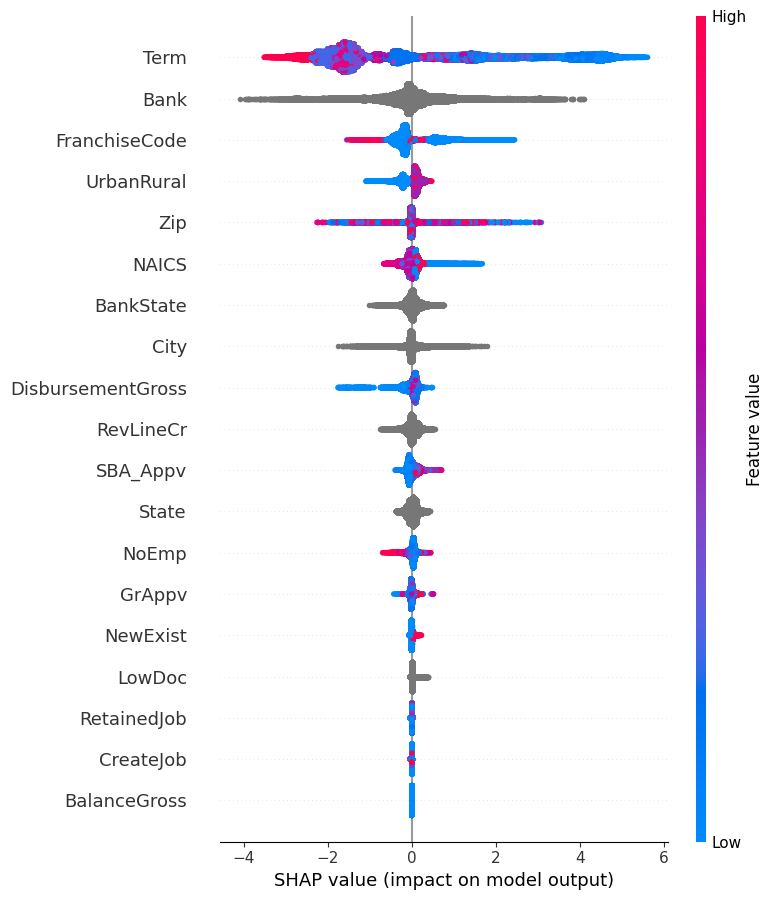

In [14]:
examine_all_reason_codes(test, test_contributions, response)

#### SHAP Values using shap.Explainer

I mostly used the shap.TreeExplainer and assume LightGBM model trained using sklearn API.

But I will try a different approach that will call SHAP function that works with LightGBM model trained using native API.

In [15]:
import shap

# Create a Shapley values explainer using the LightGBM model
explainer = shap.Explainer(model)

# Calculate Shapley values
shap_values = explainer.shap_values(test.drop(response, axis=1), check_additivity=False)

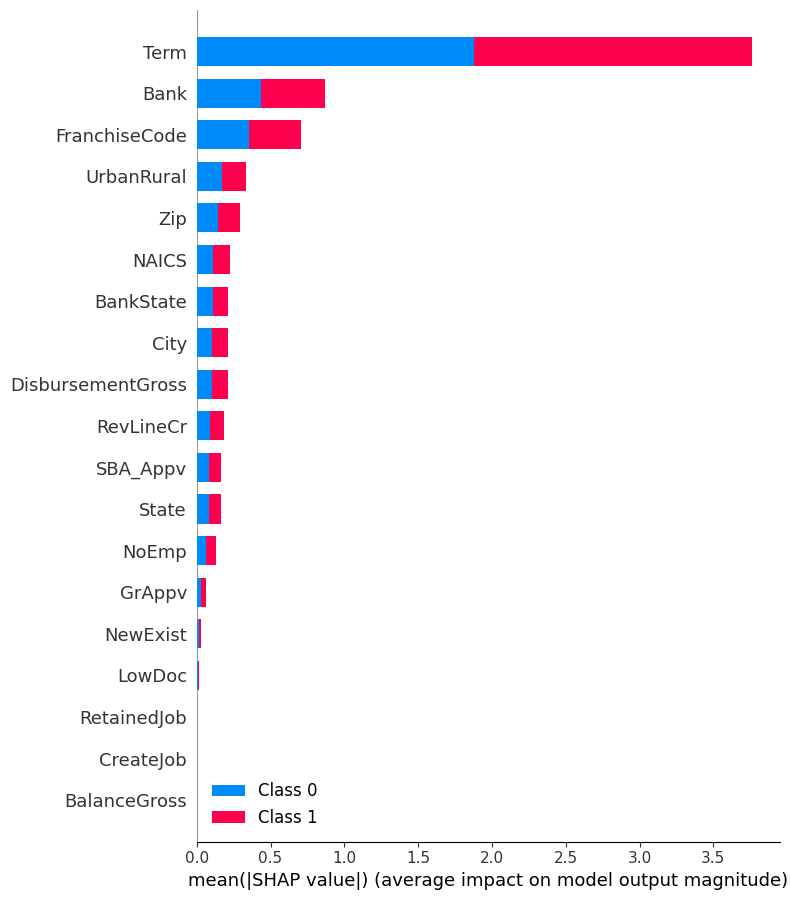

In [16]:
shap.summary_plot(shap_values, test.drop(response, axis=1).columns, plot_type="bar")